In [1]:
import tensorflow as tf
import numpy as np
import glob, os
from imageio import imread
from cv2 import resize
import cv2

In [2]:
DATASET_DIR = '../../data/cloth_folding_rgb_vids'
NUM_VIDS = 45

def get_img_pair(video_id):
    img_files = sorted(glob.glob(os.path.join(DATASET_DIR, video_id, '*.png')))
    start_img = img_files[0]
    end_img = img_files[-1]
    pair = []
    for image_file in [start_img, end_img]:
        img_original = imread(image_file)
        
        img_resized = resize(src=img_original, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
        pair.append(img_resized)
    return tuple(pair)

start_imgs = []
end_imgs= []
for vid_id in range(1, NUM_VIDS + 1):
    start_img, end_img = get_img_pair(str(vid_id))
    start_imgs.append(start_img)
    end_imgs.append(end_img)
print('Images of starting state {}'.format(np.shape(start_imgs)))
print('Images of ending state {}'.format(np.shape(end_imgs)))


Images of starting state (45, 224, 224, 3)
Images of ending state (45, 224, 224, 3)


In [3]:
n_features = 4096
n_hidden = 10 # n_features * 2

In [4]:
class Model(object):
    
    def __init__(self):
        self.w1_i = tf.Variable(tf.random.normal([n_features, n_hidden], dtype=tf.double), name="w1", dtype=tf.double)
        tf.summary.histogram("w1", self.w1_i)
        self.b1_i = tf.Variable(tf.random.normal([n_hidden], dtype=tf.double), name="b1", dtype=tf.double)
        tf.summary.histogram("b1", self.b1_i)
        
        self.w2_o = tf.Variable(tf.random.normal([n_hidden, 1], dtype=tf.double), name="w2")
        tf.summary.histogram("w2", self.w2_o)
        self.b2_o = tf.Variable(tf.random.normal([1], dtype=tf.double), name="b2")
        tf.summary.histogram("b2", self.b2_o)

    def __call__(self, x, y):
        h1 = tf.nn.dropout(tf.nn.relu(tf.matmul(x, self.w1_i) + self.b1_i), rate=0.5)
        tf.summary.histogram("h1", h1)
        h2 = tf.nn.dropout(tf.nn.relu(tf.matmul(y, self.w1_i) + self.b1_i), rate=0.5)
        tf.summary.histogram("h2", h2)
        
        s1 = tf.matmul(h1, self.w2_o) + self.b2_o
        s2 = tf.matmul(h2, self.w2_o) + self.b2_o
        
        s12 = s1 - s2
        s12_flat = tf.reshape(s12, [-1])
        
        return s12_flat
    
    def get_embeddings_s1(self, x):
        h1 = tf.nn.dropout(tf.nn.relu(tf.matmul(x, self.w1_i) + self.b1_i), rate=0.5)
        s1 = tf.matmul(h1, self.w2_o) + self.b2_o
        return s1

    def get_embeddings_s2(self, x, y):
        h1 = tf.nn.dropout(tf.nn.relu(tf.matmul(x, self.w1_i) + self.b1_i), rate=0.5)
        h2 = tf.nn.dropout(tf.nn.relu(tf.matmul(y, self.w1_i) + self.b1_i), rate=0.5)
        
        s1 = tf.matmul(h1, self.w2_o) + self.b2_o
        s2 = tf.matmul(h2, self.w2_o) + self.b2_o
        return s2
        

In [5]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [6]:
def loss(model, inputs, inputs2):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model(inputs, inputs2) + 1, labels=tf.zeros_like(model(inputs, inputs2))))

In [7]:
def train_step(model, inputs, inputs2):
    trainable_variables = [model.w1_i, model.b1_i, model.w2_o, model.b2_o]
    with tf.GradientTape() as t:
        current_loss = loss(model, inputs, inputs2)
        
    grads = t.gradient(current_loss, trainable_variables)
    optimizer.apply_gradients(zip(grads,trainable_variables))
    return current_loss

In [8]:
model = Model()

In [9]:
print('Loading model...')
base_model = tf.keras.applications.VGG16(weights='imagenet', pooling=max)
vgg16 = tf.keras.Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)
print('Done loading!')

Loading model...
Done loading!


In [10]:
print(len(start_imgs))
print(np.shape(start_imgs[0]))

45
(224, 224, 3)


In [11]:
start_imgs_embedded = np.asarray([vgg16.predict(tf.expand_dims(start_imgs[i], 0)) for i in range(0, len(start_imgs))])
end_imgs_embedded = np.asarray([vgg16.predict(tf.expand_dims(end_imgs[i], 0)) for i in range(0, len(end_imgs))])

In [12]:
idxs = np.random.choice(NUM_VIDS, NUM_VIDS, replace=False)
train_idxs = np.array(idxs[0:int(NUM_VIDS * 0.75)])
test_idxs = np.array(idxs[int(NUM_VIDS * 0.75):])

train_start_imgs = start_imgs_embedded[train_idxs].astype(np.double)
train_end_imgs = end_imgs_embedded[train_idxs].astype(np.double)
test_start_imgs = start_imgs_embedded[test_idxs].astype(np.double)
test_end_imgs = end_imgs_embedded[test_idxs].astype(np.double)

print('Train start imgs {}'.format(np.shape(train_start_imgs)))
print('Train end imgs {}'.format(np.shape(train_end_imgs)))
print('Test start imgs {}'.format(np.shape(test_start_imgs)))
print('Test end imgs {}'.format(np.shape(test_end_imgs)))

Train start imgs (33, 1, 4096)
Train end imgs (33, 1, 4096)
Test start imgs (12, 1, 4096)
Test end imgs (12, 1, 4096)


In [13]:
for epoch in range(0, 100):
    for i in range(np.shape(train_start_imgs)[0]):
        err = train_step(model, train_start_imgs[i:i+1,:], train_end_imgs[i:i+1,:])
    
    print("Step %d Train Loss %f " % (epoch, err.numpy()))
        
    s1_val = model.get_embeddings_s1(test_start_imgs)
    s2_val = model.get_embeddings_s2(test_start_imgs, test_end_imgs)

    print('Accuracy: {}%'.format(100 * np.mean(s1_val.numpy() < s2_val.numpy())))

Step 0 Train Loss 0.000000 
Accuracy: 75.0%
Step 1 Train Loss 0.000000 
Accuracy: 91.66666666666666%
Step 2 Train Loss 0.000000 
Accuracy: 91.66666666666666%
Step 3 Train Loss 0.000000 
Accuracy: 91.66666666666666%
Step 4 Train Loss 0.000000 
Accuracy: 83.33333333333334%
Step 5 Train Loss 0.000000 
Accuracy: 91.66666666666666%
Step 6 Train Loss 0.000000 
Accuracy: 100.0%
Step 7 Train Loss 0.000000 
Accuracy: 100.0%
Step 8 Train Loss 0.000000 
Accuracy: 91.66666666666666%
Step 9 Train Loss 0.000000 
Accuracy: 91.66666666666666%
Step 10 Train Loss 0.000000 
Accuracy: 100.0%
Step 11 Train Loss 0.000000 
Accuracy: 100.0%
Step 12 Train Loss 0.000000 
Accuracy: 100.0%
Step 13 Train Loss 0.000000 
Accuracy: 100.0%
Step 14 Train Loss 0.000000 
Accuracy: 100.0%
Step 15 Train Loss 0.000000 
Accuracy: 100.0%
Step 16 Train Loss 0.000000 
Accuracy: 91.66666666666666%
Step 17 Train Loss 0.000000 
Accuracy: 100.0%
Step 18 Train Loss 0.000000 
Accuracy: 100.0%
Step 19 Train Loss 0.000000 
Accuracy: 10

In [14]:
def get_img_seq(video_id):
    img_files = sorted(glob.glob(os.path.join(DATASET_DIR, video_id, '*.png')))
    imgs = []
    for image_file in img_files:
        img_original = imread(image_file)
        img_resized = resize(src=img_original, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
        imgs.append(img_resized)
    return imgs

imgs = get_img_seq('1')

In [15]:
imgs_embedded = np.asarray([vgg16.predict(tf.expand_dims(imgs[i], 0)) for i in range(0, len(imgs))], dtype=np.double)

In [16]:
scores = model.get_embeddings_s1(imgs_embedded)

In [17]:
print(np.shape(imgs_embedded))
print(imgs_embedded)

(50, 1, 4096)
[[[4.39761019 5.10273409 0.         ... 0.         0.         0.        ]]

 [[5.61068535 0.40652528 0.         ... 0.         0.         0.        ]]

 [[0.         3.15659428 0.         ... 0.         0.         0.        ]]

 ...

 [[0.         1.07057333 0.         ... 0.         0.         0.        ]]

 [[0.         0.579449   0.         ... 0.         0.         0.        ]]

 [[0.         1.10245872 0.         ... 0.         0.         0.        ]]]


In [18]:
print(np.shape(scores))
print(scores[-1])
print(np.squeeze(scores))

(50, 1, 1)
tf.Tensor([[228896.66277535]], shape=(1, 1), dtype=float64)
[-1.91952623e+03 -1.07187876e+05  7.28958262e+02 -3.60005979e+04
 -8.39378035e+04 -9.38686789e+04  6.08253047e+03 -4.25968029e+04
 -3.33077211e+04 -5.88214359e+04 -1.31881860e+04  1.38274459e+03
 -1.82692048e+04 -1.60671859e+03  3.73250951e+04  7.81555931e+03
  2.36588977e+04  9.58308373e+04  1.01217473e+05  3.08619511e+04
  7.50640697e+04  4.36155162e+04  1.09276200e+05  1.90220942e+04
 -2.76881556e+04  9.07007237e+03  8.43033006e+04  9.14871219e+04
  1.01476545e+05  3.71534845e+04  5.67049292e+04  4.18472341e+04
  9.90676273e+04  9.43268709e+04  9.11648927e+04  9.32741693e+04
  3.67759863e+04 -4.43843567e-01 -3.67641171e+03  1.41086258e+05
  8.08852243e+04  1.60307626e+04  8.35298851e+04  2.55629300e+05
  1.24260392e+05  5.03623665e+04  2.25069158e+05  1.63582695e+05
  1.63253564e+05  2.28896663e+05]


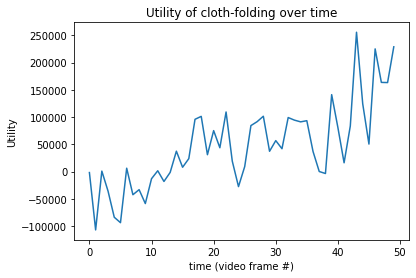

In [19]:
from matplotlib import pyplot as plt
plt.figure()
plt.title('Utility of cloth-folding over time')
plt.xlabel('time (video frame #)')
plt.ylabel('Utility')
plt.plot(np.squeeze(scores))
plt.show()